# 자전거 대여 예측모델-autogluon

역사적 이용 패턴 + 날씨 데이터를 결합하여
워싱턴 D.C. Capital Bikeshare 프로그램의 시간별 자전거 수요를 예측해보자가 
이 대회의 목표 입니다.

# 목차
1. 데이터 로드 및 탐색
2. 컬럼별 데이터 분석 및 시각화
3. 전처리 및 특성 엔지니어링
4. 모델링 및 최초 성능확인
5. 모델링 (AutoGluon) 과 앙상블
6. 내부평가 및 Autogluon submission.csv 파일 생성

# 1. 데이터 로드 및 탐색

In [1]:
import pandas as pd
import numpy as np
import missingno as msno #pip install missingno # 결측치를 절대로 놓치지않겠다는 의미의 그래프!
import matplotlib.pyplot as plt
import IPython.display as ipd # 뒤에서 데이터들을 한 번에 보여주기 위해서 채용
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from autogluon.tabular import TabularPredictor
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
submission = pd.read_csv("data/sampleSubmission.csv")

In [2]:
train.shape, test.shape # 전체적인 트레인과 테스트의 행과 열의 모양을 확인

((10886, 12), (6493, 9))

In [3]:
train.isnull().sum() # 결측치 확인

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [4]:
test.isnull().sum() # 결측치 확인

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

In [5]:
train.describe() # 카운트의 평균값191, 표준편차181, 최댓값977

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [6]:
test.describe() # 캐쥬얼, 레지스털드, 카운트가 테스트에서는 빠져있는 걸 확인

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000,6493.000000
mean,2.493300,0.029108,0.685815,1.436778,20.620607,24.012865,64.125212,12.631157
std,1.091258,0.168123,0.464226,0.648390,8.059583,8.782741,19.293391,8.250151
min,1.000000,0.000000,0.000000,1.000000,0.820000,0.000000,16.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.940000,16.665000,49.000000,7.001500
50%,3.000000,0.000000,1.000000,1.000000,21.320000,25.000000,65.000000,11.001400
75%,3.000000,0.000000,1.000000,2.000000,27.060000,31.060000,81.000000,16.997900
max,4.000000,1.000000,1.000000,4.000000,40.180000,50.000000,100.000000,55.998600


(train.Head)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32



(train.Random Sample)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10454,2012-12-02 00:00:00,4,0,0,2,12.30,15.910,87,6.0032,9,108,117
8700,2012-08-04 21:00:00,3,0,0,1,32.80,38.635,59,16.9979,96,193,289
1273,2011-03-17 21:00:00,1,0,1,1,17.22,21.210,62,15.0013,19,119,138



(train.Tail)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,2012-12-19 23:00:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88



                 TEST DATA CHECK                  

(test.Head)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000



(test.Random Sample)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
216,2011-01-30 07:00:00,1,0,0,1,5.74,10.605,86,0.0000
5846,2012-10-26 10:00:00,4,0,1,2,22.14,25.760,88,7.0015
530,2011-03-22 23:00:00,2,0,1,2,16.40,20.455,58,16.9979



(test.Tail)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981
6492,2012-12-31 23:00:00,1,0,1,1,10.66,13.635,65,8.9981


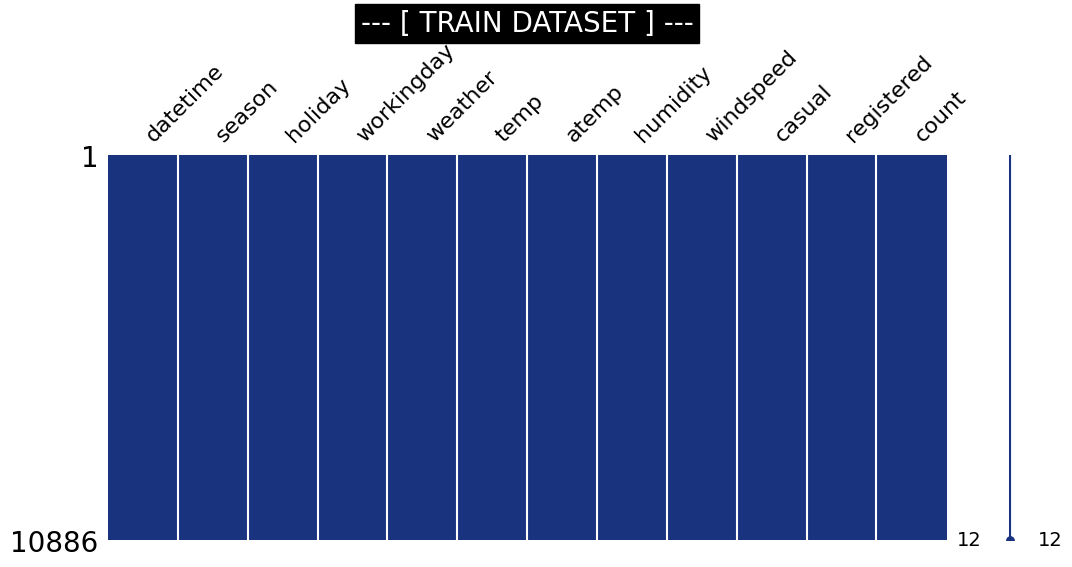

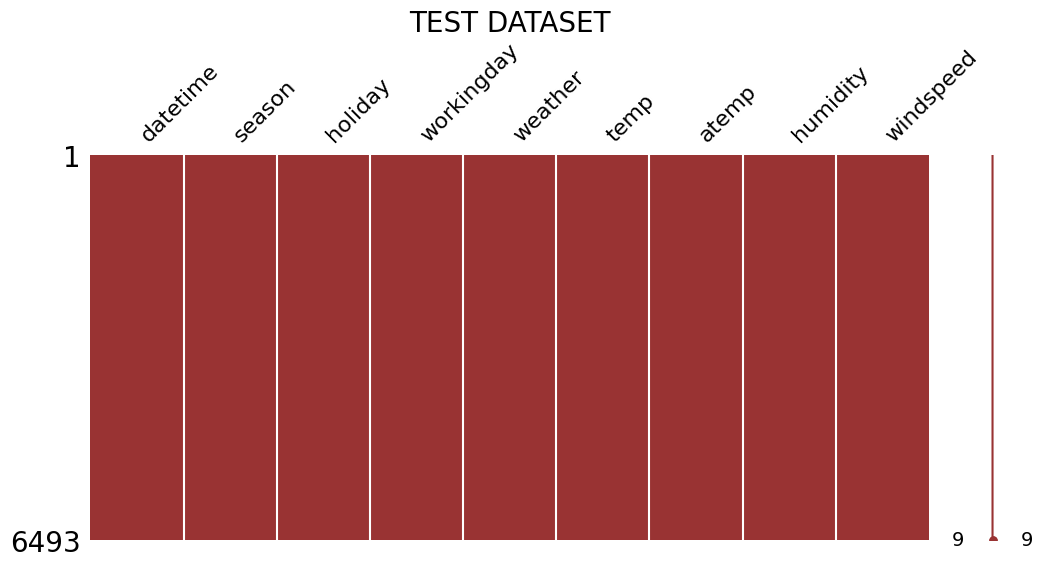


------------------------------ [ Train Info ] ------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB

------------------------------ [ Test Info ] ------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 c

In [7]:
print("(train.Head)") # 워킹데이도0, 홀리데이도0이면 원래 쉬는 날. 풍속이 계속0인 점 확인
ipd.display(train.head(3))

print("\n(train.Random Sample)")
ipd.display(train.sample(3))

print("\n(train.Tail)") # 19일 23가 마지막인 점 확인
ipd.display(train.tail(3))

print("\n" + "="*50)
print("TEST DATA CHECK".center(50))
print("="*50 + "\n")

print("(test.Head)")
ipd.display(test.head(3))

print("\n(test.Random Sample)")
ipd.display(test.sample(3))

print("\n(test.Tail)")
ipd.display(test.tail(3))
msno.matrix(train, figsize=(12,5), color=(0.1, 0.2, 0.5))
plt.title("--- [ TRAIN DATASET ] ---", fontsize=20, backgroundcolor='black', color='white')
plt.show() # 컬럼갯수 12개 확인, 미싱노 그래프로 결측치 이상 없는 거 확인.
msno.matrix(test, figsize=(12,5), color=(0.6, 0.2, 0.2))
plt.title("TEST DATASET", fontsize=20)
plt.show() # 컬럼갯수 9개 확인, 미싱노 그래프로 결측치 이상 없는 거 확인.
print("\n" + "-"*30 + " [ Train Info ] " + "-"*30)
train.info() #datetime의 오브젝트가 글자열 그러니까 문자열로 보여서 타입변환 필요 확인.
print("\n" + "-"*30 + " [ Test Info ] " + "-"*30)
test.info()

In [8]:
for data in [train, test]: # datetime을 년, 월, 일, 시간, 요일지표로 나누기
    data['datetime'] = pd.to_datetime(data['datetime'])
    data['year'] = data['datetime'].dt.year
    data['month'] = data['datetime'].dt.month
    data['day'] = data['datetime'].dt.day
    data['hour'] = data['datetime'].dt.hour
    data['dayofweek'] = data['datetime'].dt.dayofweek
train.shape # 컬럼갯수 17개 된 것 확인

(10886, 17)

In [9]:
# [분류 셀: 컬럼의 정체(데이터 타입) 파악] # 컬럼들을 적당히 나눌만큼 나눴으니

# 1. 고유값 개수 확인 (어떤 게 범주형이고 수치형인가?) # 그룹/항목으로 나뉜 데이터냐 or 수치로 측정/계산된 데이터냐
print("\n" + "="*20 + " [ 컬럼별 고유값 개수 ] " + "="*20)
ipd.display(train.nunique().to_frame().T) # 모든 값이 1이라고 버릴지 말지는 본인 판단에 맡긴다

# 2. 범주형 데이터 상세 확인 (고유값이 적은 데이터들)
cat_cols = [col for col in train.columns if train[col].nunique() < 10]
print("\n" + "="*20 + " [ 범주형 데이터 빈도수 ] " + "="*20)
for col in cat_cols:
    print(f"\n[{col} 항목 분포]")
    print(train[col].value_counts()) # 이상하면, 이상한 데이터나 깨진 글자확인용 unique()


==================== [ 컬럼별 고유값 개수 ] ====================


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,10886,4,2,2,4,49,60,89,28,309,731,822,2,12,19,24,7



==================== [ 범주형 데이터 빈도수 ] ====================

[season 항목 분포]
season
4    2734
2    2733
3    2733
1    2686
Name: count, dtype: int64

[holiday 항목 분포]
holiday
0    10575
1      311
Name: count, dtype: int64

[workingday 항목 분포]
workingday
1    7412
0    3474
Name: count, dtype: int64

[weather 항목 분포]
weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64

[year 항목 분포]
year
2012    5464
2011    5422
Name: count, dtype: int64

[dayofweek 항목 분포]
dayofweek
5    1584
6    1579
3    1553
0    1551
2    1551
1    1539
4    1529
Name: count, dtype: int64


In [10]:
# [검수 셀: Test 데이터와 Submission 양식 정합성 체크]

print(f"Test 데이터 개수: {len(test)}행")
print(f"샘플 제출 양식 개수: {len(submission)}행")

# 1. 행 개수 일치 확인
if len(test) == len(submission):     # 왼쪽과 오른쪽의 양이 같은가요?
    print("✅ 제출 항목 수가 일치합니다. 안심하세요!")
else:   
    print("⚠️ 주의! 개수가 다릅니다. 데이터를 다시 확인해보세요.")

# 2. 순서 동기화 확인 (ID나 datetime 기준)
# 만약 에러가 난다면 데이터에 'datetime' 컬럼이 있는지 확인해보세요!
check_sync = (test['datetime'] == submission['datetime']).all()     # 확인용
print(f"데이터 순서 일치 여부: {check_sync}")    # !! sort_values()

# 2번 위, 아래 같은 것

#check_sync = (test['ID_컬럼명'] == submission['ID_컬럼명']).all()
# 2. 순서 동기화 확인 (데이터에 따라 'datetime'을 'id'나 'index' 컬럼명으로 변경)
# 예: check_sync = (test['id'] == submission['id']).all()
id_col = 'datetime' # <--- 새로운 데이터를 쓸 때 여기만 고치면 됩니다!

check_sync = (test[id_col] == submission[id_col]).all()     #템플릿용(재사용가능)
print(f"데이터 순서 일치 여부: {check_sync}")


# 3. 예측해야 할 목표 변수 확인
target_col = list(set(submission.columns) - set(test.columns)) # sub - test
print(f"내가 예측해야 할 목표 변수: {target_col}") # [] -> "Warning message"
temp_set = set(submission.columns) - set(test.columns)

#if len(temp_set) > 0:
    #target_col = list(temp_set)
#else:
    # 만약 차이가 없다면 (이름이 똑같다면) 직접 지정! 
    # 혹은 submission에서 ID컬럼을 뺀 나머지를 타겟으로 설정
    # target_col = list(set(submission.columns) - {id_col}) 

print(f"최종 확정된 목표 변수: {target_col}")

# 4. 제출 양식 미리보기
print("\n[ 샘플 제출 양식 미리보기 ]")
ipd.display(submission.head(3)) # -> 맨 앞의 셀에서 써주세요. import IPython.display as ipd

Test 데이터 개수: 6493행
샘플 제출 양식 개수: 6493행
✅ 제출 항목 수가 일치합니다. 안심하세요!
데이터 순서 일치 여부: True
데이터 순서 일치 여부: True
내가 예측해야 할 목표 변수: ['count']
최종 확정된 목표 변수: ['count']

[ 샘플 제출 양식 미리보기 ]


,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0



==================== [ 1. count 기술 통계 ] ====================


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,2011.501929,6.521495,9.992559,11.541613,3.013963
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,2011.000000,1.000000,1.000000,0.000000,0.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,2011.000000,4.000000,5.000000,6.000000,1.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,2012.000000,7.000000,10.000000,12.000000,3.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,2012.000000,10.000000,15.000000,18.000000,5.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,2012.000000,12.000000,19.000000,23.000000,6.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,0.500019,3.444373,5.476608,6.915838,2.004585



==================== [ 2. count 분포 확인 ] ====================


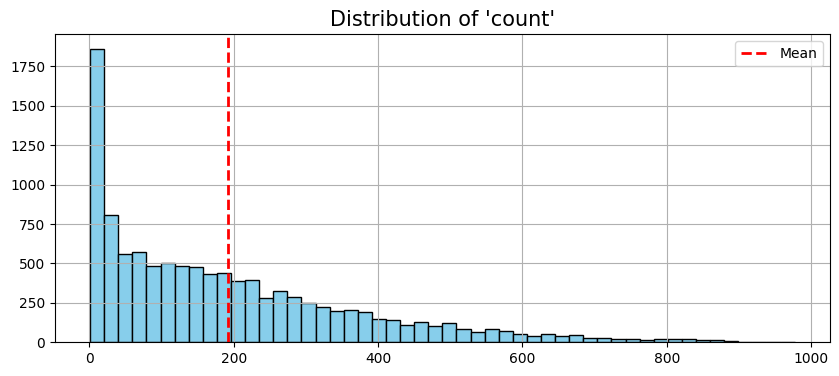


==================== [ 3. count 기준 상관관계 ] ====================


,count
count,1.000
registered,0.971
casual,0.690
hour,0.401
temp,0.394
atemp,0.390
year,0.260
month,0.167
season,0.163
windspeed,0.101


In [11]:
# [진단 셀: 데이터 속성 및 통계 분석]

# 0. 타겟 변수 설정 (검수 셀에서 찾은 target_col 활용)
# target_col이 ['count'] 형태라면 첫 번째 값을 가져옴
target = target_col[0] if len(target_col) > 0 else 'target'

# 1. 수치 데이터 통계 (이상치 확인용)
print("\n" + "="*20 + f" [ 1. {target} 기술 통계 ] " + "="*20)
ipd.display(train.describe())

# 2. 타겟 데이터 분포 (쏠림 확인용)
print("\n" + "="*20 + f" [ 2. {target} 분포 확인 ] " + "="*20)
plt.figure(figsize=(10, 4))
train[target].hist(bins=50, color='skyblue', edgecolor='black')
plt.title(f"Distribution of '{target}'", fontsize=15)
plt.axvline(train[target].mean(), color='red', linestyle='dashed', linewidth=2, label='Mean') # 평균선 추가
plt.legend()
plt.show()

# 3. 상관관계 (어떤 변수가 중요한가?)
print("\n" + "="*20 + f" [ 3. {target} 기준 상관관계 ] " + "="*20)
# 숫자형 컬럼만 추출
numeric_train = train.select_dtypes(include=[np.number])
corr_matrix = numeric_train.corr()

# 상관관계 순위 (소수점 3자리까지 예쁘게 출력)
corr_rank = corr_matrix[target].sort_values(ascending=False).to_frame().round(3)
ipd.display(corr_rank)

count: 대여량, registered: 등록자들, casual: 비정기회원, temp: 기온, atemp: 체감온도,
  workingday: 일하는날은1, 쉬는날은0(토,일+공휴일),   holyday(공휴일만): 쉬는날은1, 일하는날은0.
humidity: 습도.

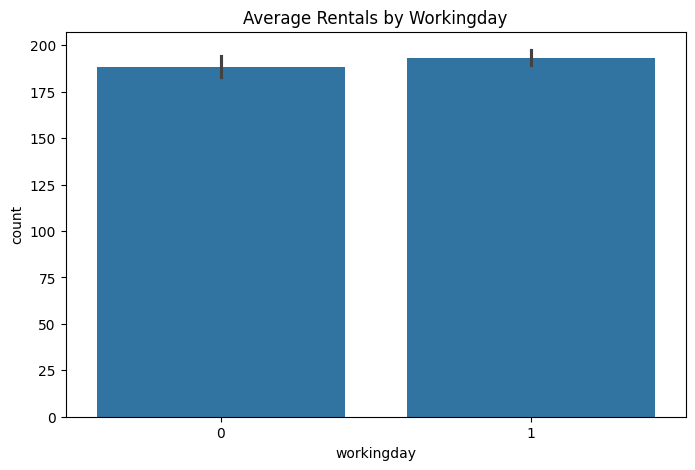

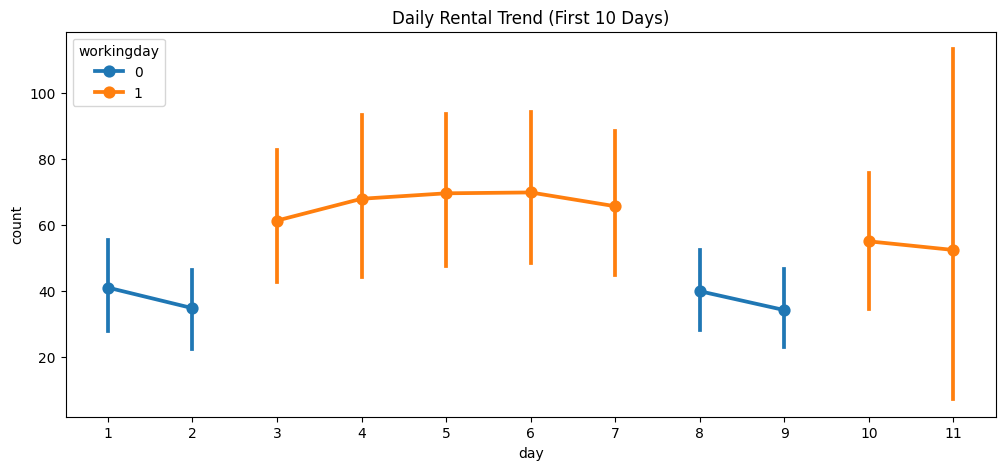

In [12]:
# 1. 평일(1)과 쉬는날(0)의 평균 대여량 차이 (막대 그래프)
plt.figure(figsize=(8, 5)) # 이것만 봐서는 모르고 밑에 것도 봐야 함
sns.barplot(data=train, x='workingday', y='count')
plt.title("Average Rentals by Workingday")
plt.show()

# 2. 10일치(약 240행)만 잘라서 날짜별 대여량 추이 보기
plt.figure(figsize=(12, 5))
sns.pointplot(data=train.head(240), x='day', y='count', hue='workingday')
plt.title("Daily Rental Trend (First 10 Days)")
plt.show()

In [13]:
train.groupby('hour')['count'].mean() # 06시~08시 폭등 시작, 16~17시 대여량 급등

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: count, dtype: float64

In [14]:
train.groupby('hour')['count'].std() # 06시~08시 , 16~17시 에서 수치량이 크게 오르락 내리락 확인

hour
0      43.620012
1      34.112105
2      26.110267
3      12.666442
4       4.217633
5      12.784293
6      54.745333
7     159.207044
8     231.723065
9      92.099209
10    101.807629
11    127.444294
12    143.881880
13    149.167185
14    147.563199
15    144.235670
16    145.664786
17    223.775485
18    219.908138
19    156.641732
20    116.411565
21     87.629319
22     69.844495
23     51.638004
Name: count, dtype: float64

<Axes: xlabel='hour', ylabel='count'>

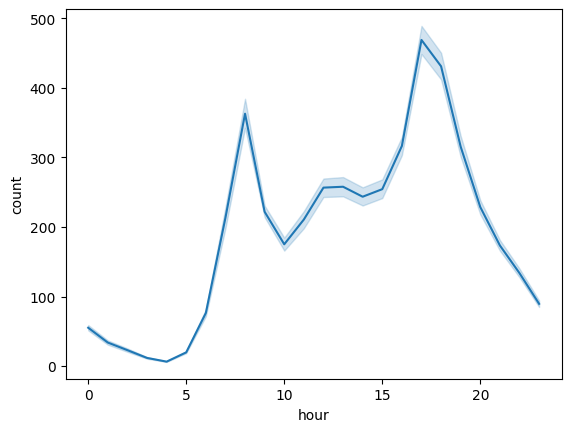

In [15]:
sns.lineplot(data=train, x='hour', y='count') # 지금까지 확인 해온 것 시각화
# 중앙의 짙은 선: 평균
# 주변의 연한 그림자: 신뢰 구간 -> 그림자가 들썩이는 폭이 넓으면 변동성이 큰 시간대

  시즌1은 봄이고, 시즌4는 겨울.
  홀리데이가 전부 0인 거로 보아 휴일이 없었나보다. 적어도 겉보기엔. -> 실제12/19일이 아니었음.

  워킹데이가 0이다가 12/19일엔 1씩 된 걸 보면 새해에만 예외로 쉬게 해주나 보군.

  weather는 왜 전부 1일까? -> 모름 -> 공교롭게도 날씨가 좋았다고 함 -> 다르게 얘기하면 
  중간에 1이 아닌 숫자도 있었을 것 -> print(df['weather'].value_counts())로 확인해보자.

  확인 결과 -> 1이 아닌 숫자도 있었음 근데 왜 4인 건 하나 뿐이지?
  temp 실제 기온이 연말이 좀 추웠네. 중간 기온들도 좀 볼까?
   -> 평균이 20이고, 최저0.8, 최대 41이네
  근데 std가 뭐지? -> 여기서 std가 어떤 의미인지 확인이 필요함 -> ?????
  근데 컬럼이 23개 랬었는데 왜 트레인 컬럼이 12개 밖에 안되는가.
  
  atemp가 뭔지 확인 -> atemp는 체감온도 -> temp를 사용할 때, 
   atemp를 같이 보면 좋을 것 같음.
  풍속이 12/19일과, 1/1의 등록자수에 영향을 주는지 확인해볼 필요는 있어보임.

  

## 2. 컬럼별 데이터 분석 및 시각화

In [16]:
train['datetime'] = pd.to_datetime(train['datetime'])
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int32         
 13  month       10886 non-null  int32         
 14  day         10886 non-null  int32         
 15  hour        10886 non-null  int32         
 16  dayofweek   10886 non-

In [17]:
train['year'] = train['datetime'].dt.year
train['hour'] = train['datetime'].dt.hour   
train['dayofweek'] = train['datetime'].dt.dayofweek
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


In [18]:
train['day'].value_counts().sort_index() # 데이터 중간에 빈 게 없는지 확인

day
1     575
2     573
3     573
4     574
5     575
6     572
7     574
8     574
9     575
10    572
11    568
12    573
13    574
14    574
15    574
16    574
17    575
18    563
19    574
Name: count, dtype: int64

In [19]:
# 모든 행(Rows) 다 보기 (주의: 행이 너무 많으면 브라우저가 멈출 수 있음)
pd.set_option('display.max_rows', None)

# 모든 열(Columns) 다 보기
pd.set_option('display.max_columns', None)

# 확인 후 다시 원래대로 돌리고 싶을 때 (생략 모드)
# pd.reset_option('display.max_rows'

In [20]:
train['datetime'].diff().value_counts() #1 11일이나 12일 넘게 공백인 날이 많음.

datetime
0 days 01:00:00     10820
0 days 02:00:00        36
12 days 01:00:00       13
11 days 01:00:00        8
0 days 03:00:00         5
0 days 13:00:00         1
9 days 01:00:00         1
10 days 01:00:00        1
Name: count, dtype: int64

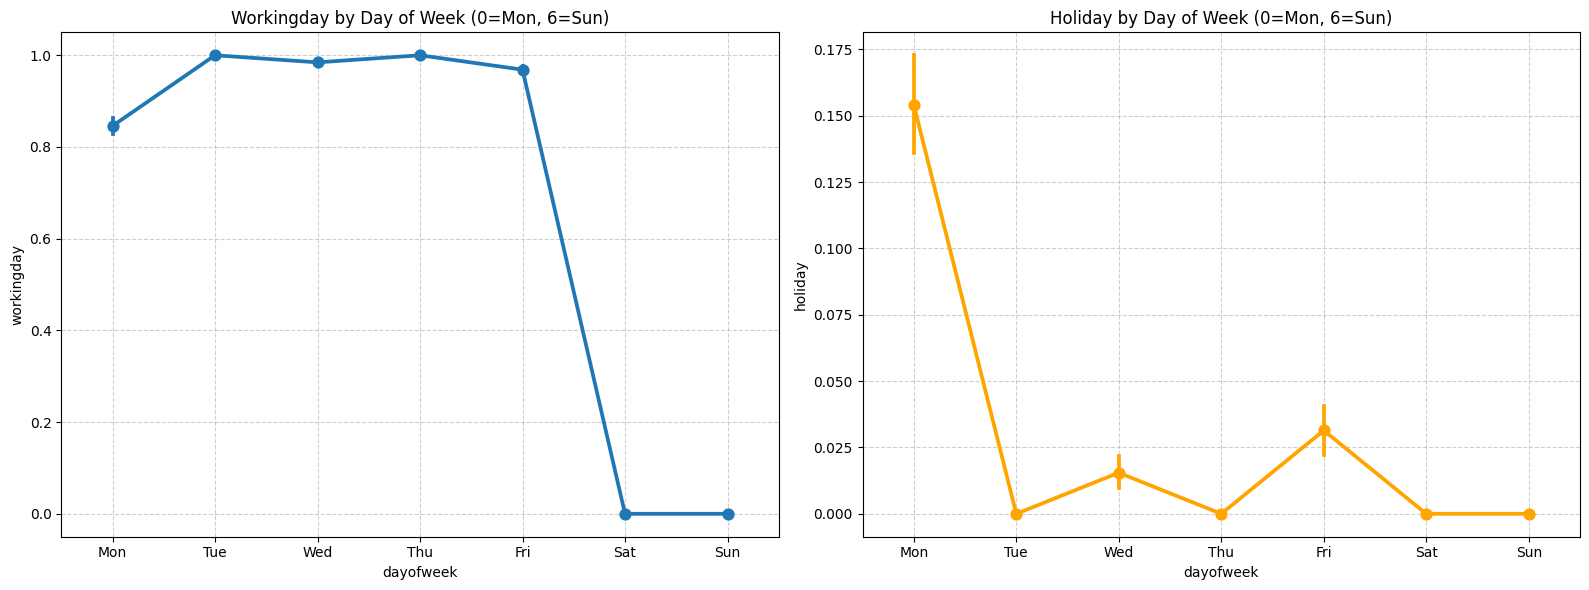

In [21]:
# 1. 전처리: datetime에서 요일(dayofweek) 추출 (0=월, 6=일)
if 'datetime' in train.columns:
    train['datetime'] = pd.to_datetime(train['datetime'])
    train['dayofweek'] = train['datetime'].dt.dayofweek

# 2. 시각화 설정
plt.figure(figsize=(16, 6))

# 첫 번째 그래프: 요일별 워킹데이 (평일은 1, 주말/공휴일은 0)
plt.subplot(1, 2, 1)
sns.pointplot(data=train, x='dayofweek', y='workingday')
plt.title('Workingday by Day of Week (0=Mon, 6=Sun)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True, linestyle='--', alpha=0.6)

# 두 번째 그래프: 요일별 홀리데이 (공휴일만 1, 아니면 0)
plt.subplot(1, 2, 2)
sns.pointplot(data=train, x='dayofweek', y='holiday', color='orange')
plt.title('Holiday by Day of Week (0=Mon, 6=Sun)')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

## 2.1 컬럼별 갯수 재확인

In [22]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'hour', 'dayofweek'],
      dtype='object')

In [23]:
train.info()
# 결측치가 0개인 거 확인함, 확인.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int32         
 13  month       10886 non-null  int32         
 14  day         10886 non-null  int32         
 15  hour        10886 non-null  int32         
 16  dayofweek   10886 non-

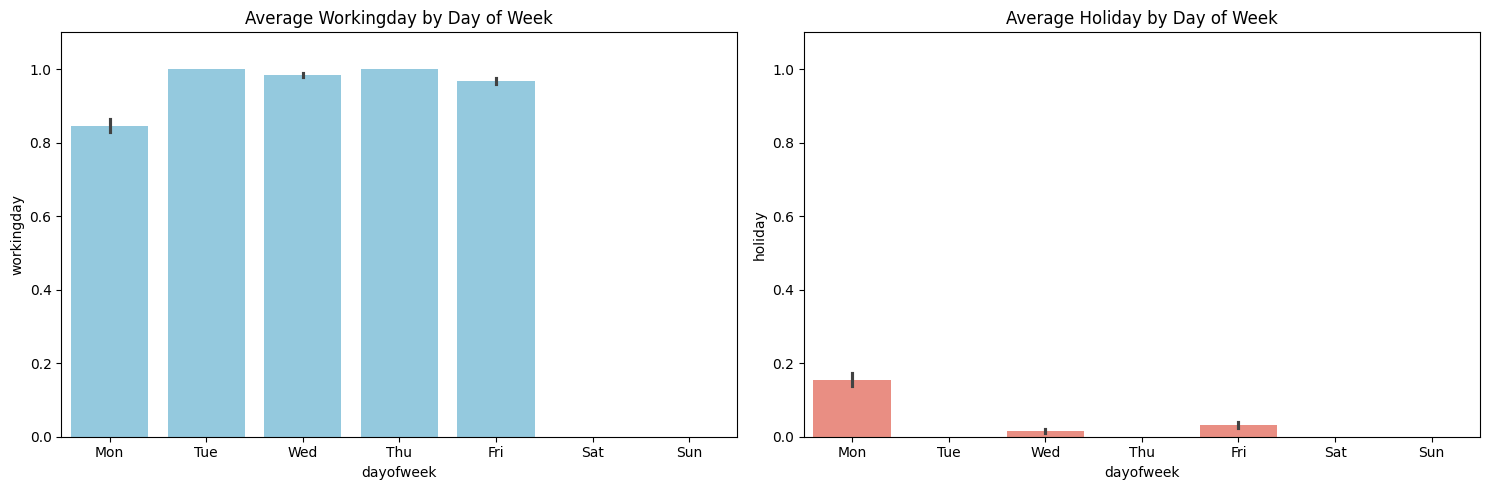

In [24]:
# 시각화의 원리: sns.pointplot이나 barplot은 데이터 전체를 훑어서 "모든 월요일의 평균", 
# "모든 화요일의 평균"을 계산해 일주일이라는 가상의 시간표를 만들어낸 것입니다.

# 요일별 이름 리스트 (0=월요일, 6=일요일)
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(15, 5))

# 1. 요일별 Workingday 비율
plt.subplot(1, 2, 1)
sns.barplot(data=train, x='dayofweek', y='workingday', color='skyblue')
plt.title('Average Workingday by Day of Week')
plt.xticks(range(7), day_names)
plt.ylim(0, 1.1) # 0과 1 사이를 명확히 보기 위함

# 2. 요일별 Holiday 비율
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='dayofweek', y='holiday', color='salmon')
plt.title('Average Holiday by Day of Week')
plt.xticks(range(7), day_names)
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

# 2.2 시간대별 평균 대여량 분석

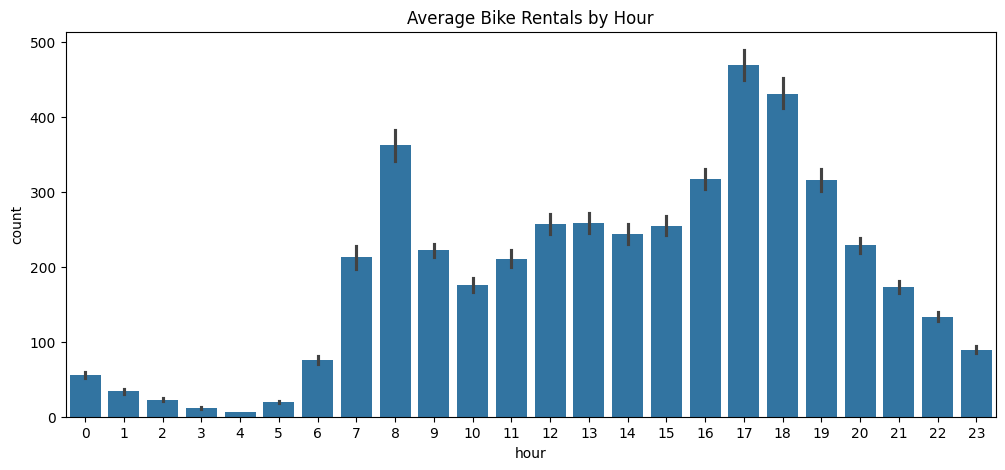

In [25]:
# 1. 시간대별(hour) 평균 대여량(count) 시각화

plt.figure(figsize=(12, 5))  #figsize=(12, 5): 도화지의 가로와 세로 길이를 정하는 옵션
sns.barplot(x='hour', y='count', data=train)
plt.title('Average Bike Rentals by Hour')
plt.show()
# 오후 5시, 아침8시가 유독 뾰족함. -> 새벽 3시와의 차이가 심한 거로 보아
# 새벽5시나 새벽6시까지만 자전거를 재배치하면 될 것으로 보이는 것을 알 수 있음.
# 오후 19시와 오전 8시의 검은색 줄의 길이가 유독 차이가 남. 분명 길이가 비슷함에도 차이가 나는 걸로 보아
# 뭔가 이상한 걸 알 수 있음.

# 2.3 기상 및 기온에 따른 대여량 분석 

2.3.1 날씨

In [26]:
print(train['weather'].value_counts())

weather
1    7192
2    2834
3     859
4       1
Name: count, dtype: int64


2.3.2 기온

In [27]:
# 기온 데이터의 최솟값, 25%, 50%, 75%, 최댓값 확인
print(train['temp'].describe())

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64


2.3.3 체감온도

In [28]:
print(train['atemp'].describe())
# temp와 atemp의 평균값과 표준편차는 별 차이가 없음. 전체적으로 같이 움직이는 듯 함.

count    10886.000000
mean        23.655084
std          8.474601
min          0.760000
25%         16.665000
50%         24.240000
75%         31.060000
max         45.455000
Name: atemp, dtype: float64


2.3.4 온도와 대여량의 관계 시각화

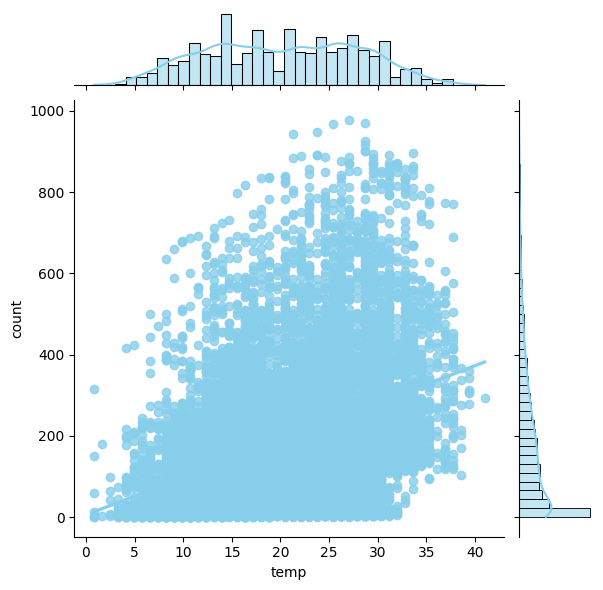

In [29]:
# 온도와 대여량의 관계 (산점도 + 회귀선)
sns.jointplot(data=train, x='temp', y='count', kind='reg', color='skyblue')
plt.show()


# 2.4 풍속과 등록자수 및 상관관계 분석

In [30]:
# 'datetime'에서 월과 일을 추출하여 특정 날짜만 필터링
target_days = train[((train['month'] == 12) & (train['day'] == 19)) | 
                 ((train['month'] == 1) & (train['day'] == 1))]

# 날짜, 풍속, 등록자수, 전체대여량만 선택해서 출력
print(target_days[['datetime', 'windspeed', 'registered', 'count']])

                 datetime  windspeed  registered  count
0     2011-01-01 00:00:00     0.0000          13     16
1     2011-01-01 01:00:00     0.0000          32     40
2     2011-01-01 02:00:00     0.0000          27     32
3     2011-01-01 03:00:00     0.0000          10     13
4     2011-01-01 04:00:00     0.0000           1      1
5     2011-01-01 05:00:00     6.0032           1      1
6     2011-01-01 06:00:00     0.0000           0      2
7     2011-01-01 07:00:00     0.0000           2      3
8     2011-01-01 08:00:00     0.0000           7      8
9     2011-01-01 09:00:00     0.0000           6     14
10    2011-01-01 10:00:00    16.9979          24     36
11    2011-01-01 11:00:00    19.0012          30     56
12    2011-01-01 12:00:00    19.0012          55     84
13    2011-01-01 13:00:00    19.9995          47     94
14    2011-01-01 14:00:00    19.0012          71    106
15    2011-01-01 15:00:00    19.9995          70    110
16    2011-01-01 16:00:00    19.9995          52

In [31]:
# 전체 데이터에서 풍속과 등록자수의 상관관계 계산
correlation = train['windspeed'].corr(train['registered'])
print(f"풍속과 등록자수 사이의 상관계수: {correlation:.2f}")
# 0.09인 거로 보아 풍속과 등록자수는 관계가 없는 듯 함.

풍속과 등록자수 사이의 상관계수: 0.09


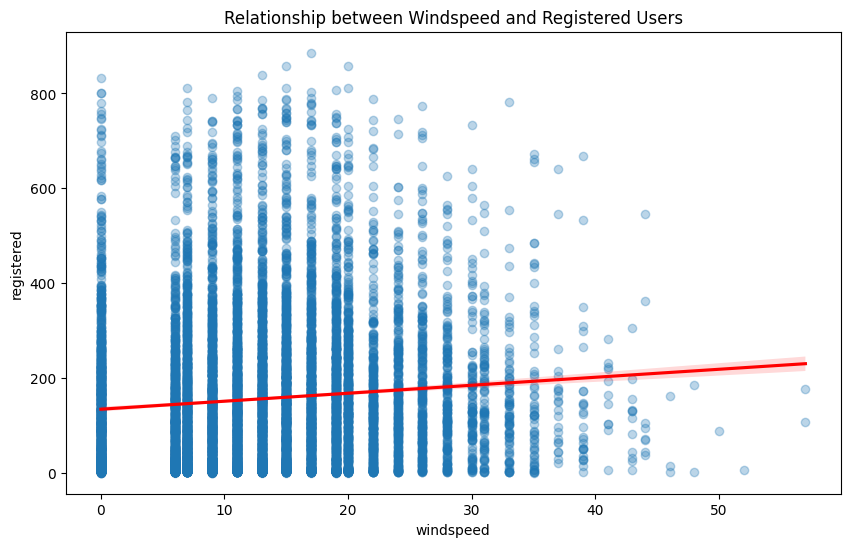

In [32]:
plt.figure(figsize=(10, 6))
# 산점도에 추세선(regline)을 추가해서 경향성 확인 (빨간선이 추세선임) 
sns.regplot(x='windspeed', y='registered', data=train, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Relationship between Windspeed and Registered Users')
plt.show()
# 풍속이 0~30일 때, 등록자들이 많고, 풍속이 30을 넘어가면 등록자들이 점차 줄어드는 것으로 보아 관계가 있어보임.
# 그런데 위에서 상관관계만 봤을 때는 관계가 없다고 판단되었었음. 뭔가 이상하니 확인 필요함.
# 또는 제외할 필요가 있을지도 모름. 그리고... 0과 10사이에 왜 비어있지?

# 2.5 평일/주말 시간대별 대여량 시각화 및 분석

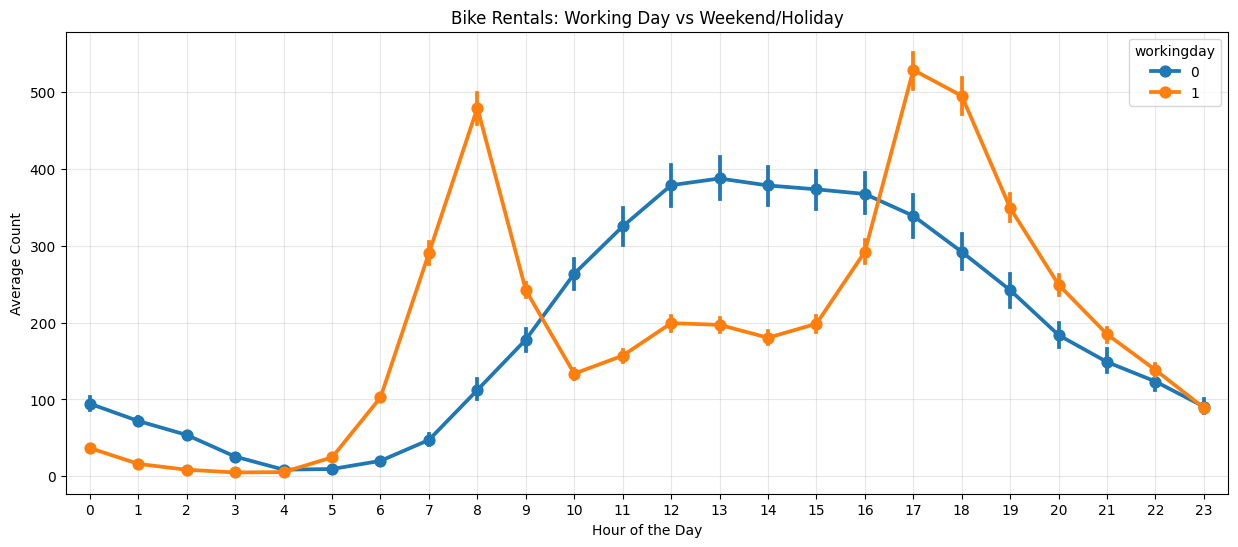

In [33]:
# 1. 도화지 준비 (가로로 길게)
plt.figure(figsize=(15, 6))

# 2. 시간대별 대여량을 평일/주말(hue='workingday')로 나누어 그리기
sns.pointplot(data=train, x='hour', y='count', hue='workingday')

plt.title('Bike Rentals: Working Day vs Weekend/Holiday')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Count')
plt.grid(True, alpha=0.3)
plt.show()

새벽4시에 사용량이 최저점임. 파란색선은 쉬는 날, 주황색선은 일하는 날.
대체로 이용하는 사람들이 적어지는 시간대에는 고정 이용객들만 이용하는 것을 알 수 있음.

# 3. 전처리와 특성 엔지니어링

3.1 결측치 재확인

In [34]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
year          0
month         0
day           0
hour          0
dayofweek     0
dtype: int64

3.2 전처리를 실행하기에 앞서 할지말지에 대한 지금까지의 분석 재확인

df['count'].describe()
평균이 181인데 최대가 977임. 대여수량 차이가 너무 심함.

시간대별(hour) 평균 대여량(count) 시각화에서
오후 5시, 아침8시가 유독 뾰족함. -> 새벽 3시와의 차이가 심한 거로 보아 이상함.
오후 19시와 오전 8시의 검은색 줄의 길이가 유독 차이가 남. 분명 길이가 비슷함에도 차이가 나는 걸로 보아
뭔가 이상한 걸 알 수 있음.

풍속과 등록자들 사이의 이상한 의문점. 풍속과 등록자들의 상관관계는 관계없다고 얘기하나,
풍속 30 이상일 때, 등록자들이 점차 줄어드는 걸 보면 관계가 있음. 그러니 이상한 데이터임.

전체적으로 이상치가 많은 데이터들이라 
모델이 이 '너무 튀는 값'에 휘둘리지 않도록 
나중에 Log Transformation(로그 변환)을 할지 결정하는 근거가 됨.



# feature engineering
# 전체적으로 새벽4시는 규칙적이고 변동성이 적어서 모델이 안정적으로 점수를 확보할 수 있는 시간대임.



In [35]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,dayofweek
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


3.3 풍속의 전처리 여부 검토

    풍속과 등록자들 사이의 이상한 의문점. 풍속과 등록자들의 상관관계는 관계없다고 얘기하나,
    풍속 30 이상일 때, 등록자들이 점차 줄어드는 걸 보면 관계가 있음. 그러니 이상한 데이터임.
    지워 버리는 게 맞는 것 같긴 하나, 풍속을 오토글론이 어떤 방식으로 학습할지 몰라 남겨두고 
    결과를 확인하는 편이 좋다고 판단. 그러나 로그 함수로 리스크 관리하는 게 
    좋은 것 같으니 추후 모델링 과정에서 다시 조정할 예정임. 
    *풍속 0과 10사이를 어떤 수로 채울지가 관건
    -> overall_mean = df[df['windspeed'] >= 10]['windspeed'].mean()
    df.loc[df['windspeed'] < 10, 'windspeed'] = overall_mean을 통해 완료

# 4. 모델링 및 최초 성능확인

In [36]:
# =====================================================
# 1️⃣ 데이터 로딩
# =====================================================
train = pd.read_csv("data/train.csv")  # 1~19일 학습용
test = pd.read_csv("data/test.csv")    # 20~말일 제출용

# =====================================================
# 2️⃣ 피처 엔지니어링
# =====================================================
for df in [train, test]:
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['hour'] = df['datetime'].dt.hour
    df['weekday'] = df['datetime'].dt.weekday
    df['month'] = df['datetime'].dt.month
overall_mean = df[df['windspeed'] >= 10]['windspeed'].mean() # 풍속이 10이상인 데이터들의 평균 구하고,
df.loc[df['windspeed'] < 10, 'windspeed'] = overall_mean # 풍속이 10 미만(0 포함)인 모든 행을 찾아 전체 평균으로 교체
# 학습용: 타겟 제거
y_train = np.log1p(train['count']) 
train = train.drop(columns=['count', 'casual', 'registered'])

# =====================================================
# 3️⃣ 범주형 변수 One-Hot Encoding (최신 scikit-learn)
# =====================================================
categorical_cols = ['season', 'weather', 'weekday', 'month', 'hour']
encoder = OneHotEncoder(sparse_output=False, drop='first')

encoder.fit(train[categorical_cols])
X_train_cat = encoder.transform(train[categorical_cols])
X_test_cat = encoder.transform(test[categorical_cols])

# 숫자형 컬럼 결합
num_cols = ['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed']
X_train = np.hstack([X_train_cat, train[num_cols].values])
X_test = np.hstack([X_test_cat, test[num_cols].values])

# 스케일링 (선택)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=42)

# =====================================================
# 4️⃣ 모델 학습
# =====================================================
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train_part, y_train_part)

val_preds = model.predict(X_val)
print(f"자체 검증 RMSLE: {np.sqrt(mean_squared_error(y_val, val_preds))}")
# =====================================================
# 5️⃣ 제출용 예측
# =====================================================
y_pred_log = model.predict(X_test_scaled)
y_pred = np.expm1(y_pred_log)
y_pred = np.clip(y_pred, 0, None)

submission = pd.DataFrame({
    'datetime': test['datetime'],
    'count': y_pred
})

submission = pd.DataFrame({
    'datetime': test['datetime'],
    'count': y_pred
})
submission.to_csv("submission.csv", index=False)
print("submission.csv 파일 생성 완료!")

자체 검증 RMSLE: 0.4762205530357259
submission.csv 파일 생성 완료!


# 5. 모델링(autogloun) 과 앙상블

5.1 AutoGluon 학습 및 검증과 평가

In [37]:
ag_train = pd.read_csv("data/train.csv")
ag_train['datetime'] = pd.to_datetime(ag_train['datetime'])
ag_train['hour'] = ag_train['datetime'].dt.hour
ag_train['weekday'] = ag_train['datetime'].dt.weekday
ag_train['month'] = ag_train['datetime'].dt.month
ag_train = ag_train.drop(columns=['casual', 'registered'])
overall_mean = ag_train[ag_train['windspeed'] >= 10]['windspeed'].mean()
ag_train.loc[ag_train['windspeed'] < 10, 'windspeed'] = overall_mean
predictor = TabularPredictor(
    label='count', 
    problem_type='regression',
    eval_metric='root_mean_squared_error'
).fit(
    train_data=ag_train,
    time_limit=600, 
    presets='best_quality'  # 앙상블
)
# 1. 피처의 타입, 변환 과정, 사용된 컬럼 명단을 상세히 출력
metadata = predictor.feature_metadata
print("--- [Feature Metadata Summary] ---")
print(metadata)

# 2. 각 피처가 어떤 'Generator'(생성기)를 거쳐서 만들어졌는지 계보 확인
print("\n--- [Feature Generation Pipeline] ---")
print(metadata.to_dict())
leaderboard = predictor.leaderboard(extra_info=True)
print(leaderboard)

No path specified. Models will be saved in: "AutogluonModels\ag-20260211_023546"
Verbosity: 2 (Standard Logging)


=================== System Info ===================
AutoGluon Version:  1.5.0
Python Version:     3.11.14
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22621
CPU Count:          22
Pytorch Version:    2.9.1+cpu
CUDA Version:       CUDA is not available
Memory Avail:       19.07 GB / 31.74 GB (60.1%)
Disk Space Avail:   283.40 GB / 454.67 GB (62.3%)
Presets specified: ['best_quality']
Using hyperparameters preset: hyperparameters='zeroshot'
Setting dynamic_stacking from 'auto' to True. Reason: Enable dynamic_stacking when use_bag_holdout is disabled. (use_bag_holdout=False)
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=1
DyStack is enabled (dynamic_stacking=True). AutoGluon will try to determine whether the input data is affected by stacked overfitting and enable or disable stacking as a consequence.
	This is used to identify the optimal `num_stack_levels` value. Copies of AutoGluon will be fit on subsets of the

(_ray_fit pid=15372) [1000]	valid_set's rmse: 38.3901
(_ray_fit pid=21524) [4000]	valid_set's rmse: 34.6496 [repeated 24x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(_ray_fit pid=10128) [7000]	valid_set's rmse: 35.8319 [repeated 22x across cluster]
(_ray_fit pid=16156) [10000]	valid_set's rmse: 35.535 [repeated 10x across cluster]


(_dystack pid=16492) 	-35.4695	 = Validation score   (-root_mean_squared_error)
(_dystack pid=16492) 	21.95s	 = Training   runtime
(_dystack pid=16492) 	4.06s	 = Validation runtime
(_dystack pid=16492) Fitting model: LightGBM_BAG_L1 ... Training model for up to 65.90s of the 113.69s of remaining time.
(_dystack pid=16492) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=2, gpus=0, memory=0.13%)


(_ray_fit pid=25860) [1000]	valid_set's rmse: 34.0781
(_ray_fit pid=22368) [1000]	valid_set's rmse: 33.3869


(_dystack pid=16492) 	-34.1912	 = Validation score   (-root_mean_squared_error)
(_dystack pid=16492) 	7.74s	 = Training   runtime
(_dystack pid=16492) 	0.96s	 = Validation runtime
(_dystack pid=16492) Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 53.55s of the 101.34s of remaining time.
(_dystack pid=16492) 	Fitting 1 model on all data (use_child_oof=True) | Fitting with cpus=22, gpus=0, mem=0.0/17.4 GB
(_dystack pid=16492) 	-39.0081	 = Validation score   (-root_mean_squared_error)
(_dystack pid=16492) 	2.12s	 = Training   runtime
(_dystack pid=16492) 	0.57s	 = Validation runtime
(_dystack pid=16492) Fitting model: CatBoost_BAG_L1 ... Training model for up to 50.60s of the 98.39s of remaining time.
(_dystack pid=16492) 	Fitting 8 child models (S1F1 - S1F8) | Fitting with ParallelLocalFoldFittingStrategy (8 workers, per: cpus=2, gpus=0, memory=2.24%)
(_ray_fit pid=23984) 	Ran out of time, early stopping on iteration 4437.
(_dystack pid=16492) 	-34.0776	 = Validation

--- [Feature Metadata Summary] ---
('float', [])                : 3 | ['temp', 'atemp', 'windspeed']
('int', [])                  : 6 | ['season', 'weather', 'humidity', 'hour', 'weekday', ...]
('int', ['bool'])            : 2 | ['holiday', 'workingday']
('int', ['datetime_as_int']) : 3 | ['datetime', 'datetime.year', 'datetime.day']

--- [Feature Generation Pipeline] ---
{'season': ('int', ()), 'holiday': ('int', ('bool',)), 'workingday': ('int', ('bool',)), 'weather': ('int', ()), 'temp': ('float', ()), 'atemp': ('float', ()), 'humidity': ('int', ()), 'windspeed': ('float', ()), 'hour': ('int', ()), 'weekday': ('int', ()), 'month': ('int', ()), 'datetime': ('int', ('datetime_as_int',)), 'datetime.year': ('int', ('datetime_as_int',)), 'datetime.day': ('int', ('datetime_as_int',))}
                    model  score_val              eval_metric  pred_time_val  \
0     WeightedEnsemble_L3 -32.752047  root_mean_squared_error       8.600042   
1     WeightedEnsemble_L2 -32.980739  root_mean

5.2 최종 보정

In [38]:
# predictor는 학습 시 사용한 변수명입니다
predictions = predictor.predict(test)

# 혹시 모를 음수 값 방지 (자전거 대여량은 0보다 작을 수 없으니까요)
predictions = np.clip(predictions, 0, None)

print(predictions.head())

0    13.932661
1     5.978533
2     4.653778
3     4.071386
4     3.664120
Name: count, dtype: float32


5.3 autogloun 변수 중요도 분석 및 시각화

In [39]:
fi = predictor.feature_importance(data=ag_train)
print(fi)

Computing feature importance via permutation shuffling for 12 features using 5000 rows with 5 shuffle sets...
	490.28s	= Expected runtime (98.06s per shuffle set)
	400.34s	= Actual runtime (Completed 5 of 5 shuffle sets)


            importance    stddev       p_value  n    p99_high     p99_low
hour        195.890836  1.557115  4.790394e-10  5  199.096958  192.684714
datetime     80.027931  0.726039  8.128440e-10  5   81.522855   78.533006
workingday   59.897187  1.940094  1.318985e-07  5   63.891868   55.902506
humidity     28.210805  1.258813  4.744731e-07  5   30.802718   25.618893
weekday      26.945669  0.551246  2.100700e-08  5   28.080691   25.810646
temp         22.370768  0.736605  1.408537e-07  5   23.887447   20.854088
atemp        14.032384  0.642426  5.256960e-07  5   15.355148   12.709620
weather      12.584751  0.703385  1.166184e-06  5   14.033030   11.136473
month         5.408822  0.247690  5.262510e-07  5    5.918820    4.898825
windspeed     3.167777  0.115365  2.107097e-07  5    3.405315    2.930240
holiday       1.658649  0.364312  2.621960e-04  5    2.408773    0.908525
season        0.734310  0.053232  3.291018e-06  5    0.843916    0.624704


5.4 autogloun 최종 모델 저장

In [40]:
# 1. 제출 양식 불러오기 (보통 sampleSubmission.csv가 제공됩니다)
submission = pd.read_csv('data/sampleSubmission.csv')

# 2. 예측값 채워넣기 (예측값 후처리 및 저장)
submission['count'] = predictions

# 3. 파일로 저장
submission.to_csv('my_autogluon_submission.csv', index=False)

print("제출 파일 생성 완료! 'my_autogluon_submission.csv'를 확인하세요.")

제출 파일 생성 완료! 'my_autogluon_submission.csv'를 확인하세요.


## 완료

Autogluon을 사용하여 향후 특정 시간대의 **대여 수량(count)**을 예측하는 모델을 완성하였습니다.

### 요약
- **데이터분석**: 컬럼별 대여량 분석
- **전처리와 특성엔지니어링**: 결측치 재확인 및 컬럼별 특징에 따른 전처리 여부
- **모델링**: 베이스라인 모델 생성 및 autogloun 모델 생성
- **앙상블**: presets='best_quality' 옵션을 활용한 autogluon의 최종모델 도출
- **평가**: RMSLE 평가지표를 사용하여 모델 성능 평가
- **제출**: submission_autogluon.csv 파일 생성





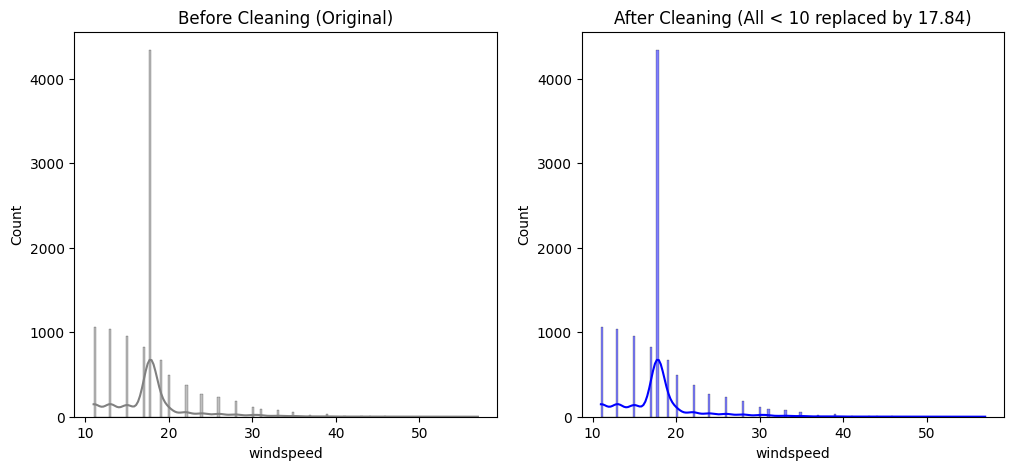

In [41]:
# 1. 시각화를 위한 axes 설정 (1행 2열)
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# [왼쪽 axes[0]] 보정 전 풍속 분포
sns.histplot(ag_train['windspeed'], kde=True, ax=axes[0], color='gray')
axes[0].set_title("Before Cleaning (Original)")

# ---------------------------------------------------------
# 2. 날씨 조건 없는 일괄 보정 규칙 적용
# ---------------------------------------------------------
# 10 이상의 정상 데이터 평균 구하기
overall_mean = ag_train[ag_train['windspeed'] >= 10]['windspeed'].mean()

# 10 미만 데이터를 일괄 보정
ag_train.loc[ag_train['windspeed'] < 10, 'windspeed'] = overall_mean
# ---------------------------------------------------------

# [오른쪽 axes[1]] 보정 후 풍속 분포
sns.histplot(ag_train['windspeed'], kde=True, ax=axes[1], color='blue')
axes[1].set_title(f"After Cleaning (All < 10 replaced by {overall_mean:.2f})")

plt.show()

# 3. 예측 및 제출
# 주의: 학습 데이터(ag_train)뿐만 아니라 테스트 데이터(test)도 똑같이 보정해야 합니다!
test.loc[test['windspeed'] < 10, 'windspeed'] = overall_mean 
preds = predictor.predict(test)